In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from collections import Counter 
from __future__ import print_function
from nltk.stem.porter import PorterStemmer

/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def data_loader():
    with open("assign_4_data.txt","r") as f:
        output_wordlist = [r.split()[0] for r in f]
        f.close()
    with open("data.txt","r") as f:
        data = f.readlines()
    with open("data.txt","r") as f:
        text = f.read()
        
    return data, text, output_wordlist

In [3]:
data, text, output_wordlist = data_loader()

## Preprocessing

In [4]:
def preprocessing(data, text, output_wordlist):
    
    
    #### Part 1: Break each message into tokens
    # sentences = sent_tokenize(text)
    n = len(data)
    tokenized_data = []
    for i in range(0,n):
        test = str(data[i])
        tokens = word_tokenize(test)
        words = [word for word in tokens if word.isalpha()]
        tokenized_data.append(words)

    tokens = word_tokenize(text)
    temp_vocab = [word for word in tokens if word.isalpha()]

    
    #### Part 2: Removing English stopwords
    stop_words = stopwords.words('english')
    stop_words = [word.lower() for word in stop_words]
    temp_vocab = [word.lower() for word in temp_vocab]
    for i in range(0,n):
        tokens = tokenized_data[i]
        words = [word.lower() for word in tokens]
        tokenized_data[i] = words
    noSW_tokenized_data = []
    for i in range(0,n):
        tokens = tokenized_data[i]
        words = [w for w in tokens if not w in stop_words]
    #     print(words)
        noSW_tokenized_data.append(words)
    noSW_vocab = [w for w in temp_vocab if not w in stop_words]

    
    
    #### Part 3: Porter Stemming
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed_data = []
    for i in range(0,n):
        words = [porter.stem(word) for word in noSW_tokenized_data[i]]
        stemmed_data.append(words)
    stemmed_vocab = [porter.stem(word) for word in noSW_vocab]

    
    
    ### Vocabulary creation
    counter = Counter(stemmed_vocab)
    most_frequent_count = 500
    most_occur = counter.most_common(most_frequent_count)
    vocab = []
    for word in most_occur:
        vocab.append(word[0]) 

    V = len(vocab)
    token_vector =  np.zeros((n, V)).tolist()
    for i in range(0,V):
        word = vocab[i]
        for j in range(0,n):
            for w in stemmed_data[j]:
                if word == w:
                    token_vector[j][i] = 1

                    
    #### Target Variable definition
    output_wordlist_num = []
    for word in output_wordlist:
        if word == 'ham':
            output_wordlist_num.append(1)
        elif word == 'spam':
            output_wordlist_num.append(0)
    
    token_vector = np.array(token_vector)
    output_wordlist_num = np.array(output_wordlist_num)

    
    
    #### Test-Train split
    train_split = 0.8
    train_size = int(train_split*n)

    X_train = token_vector[0:train_size]
    Y_train = output_wordlist_num[0:train_size]
    X_test = token_vector[train_size:]
    y_test = output_wordlist_num[train_size:].reshape((-1, 1)) 
    X = X_train
    y = Y_train.reshape((-1, 1)) 
    
    return X_train, Y_train, X_test, y_test, X, y

In [5]:
X_train, Y_train, X_test, y_test, X, y = preprocessing(data, text, output_wordlist)

## Part 1:

#we have 3 layers: input layer, hidden layer and output layer
#input layer has 500 nodes (Vocabulary size = 500)
#hidden layer has 100 nodes
#output layer has 1 node

In [6]:
np.random.seed(0)

In [7]:
def weight_initialiser(X_train, hidden_layer_nodes =100, output_nodes=1):
    dim1 = len(X_train[0])
    dim2 = hidden_layer_nodes
    dim3 = output_nodes
    weight0 = 2 * np.random.random((dim1, dim2)) - 1
    weight1 = 2 * np.random.random((dim2, dim3)) - 1
    
    return weight0, weight1

In [8]:
def sigmoid_derivative(x):
    return x * (1.0 - x)
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [9]:
def relu(x):
    return np.maximum(x,0.01) #Taking 0.01 to tackle dying Relu problem

In [10]:
def softmax(X):
#     print(X)
    exps = np.exp(X-np.max(X))
#     print("\n\n\n", exps, "\n\n\n\n\n\n")
    return exps / np.sum(exps)

def CrossEntropy_Loss(p, t):
    y = softmax(p)
    return (-np.mean(np.multiply(t, np.log(y+1e-9))))

In [11]:
def reluDerivative(x):     
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [12]:
def derivative(p, t):
    y = softmax(p)
    return (y.T-t).T

In [13]:
def forward(X_train, weight0, weight1):
    layer_0 = X_train
    layer_1 = relu(np.dot(layer_0,weight0))
    layer_2 = sigmoid(np.dot(layer_1,weight1))
    return layer_0, layer_1, layer_2

In [14]:
def backward(weight0, weight1, layer_0, layer_1, layer_2, Y_train, learning_rate):
    loss = CrossEntropy_Loss(layer_2, Y_train)
    
    layer_2_error = (Y_train - layer_2.T).T
#     loss = layer_2_error.sum()
#     layer_2_cross_derivative = derivative(layer_2, Y_train)
#     layer_2 = reluDerivative(layer_2)
#     layer_2_delta = np.dot(layer_1.T, layer_2_cross_derivative*layer_2)
    layer_2_delta_error = layer_2_error * sigmoid_derivative(layer_2)
    layer_2_delta = np.dot(layer_1.T, layer_2_delta_error)
    layer_1_error = np.dot(layer_2_delta_error, weight1.T)
    layer_1 = reluDerivative(layer_1)
    layer_1_delta = np.dot(layer_0.T, layer_1_error * layer_1)

    weight1 += learning_rate*layer_2_delta
    weight0 += learning_rate*layer_1_delta
    
    return weight0, weight1, loss

In [15]:
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches 

In [16]:
# mini_batches = create_mini_batches(X, y, 32)
def gradientDescent(X, y, X_test, y_test,learning_rate = 0.1, batch_size = 32): 
    weight0, weight1 = weight_initialiser(X_train)
    error_list = []
    test_error_list = []
    
#     max_iters = 3
#     for itr in range(max_iters): 
#         mini_batches = create_mini_batches(X, y, batch_size) 
#         for mini_batch in mini_batches: 
#             X_mini, y_mini = mini_batch
#             layer_0, layer_1, layer_2 = forward(X_mini, weight0, weight1)
#             weight0, weight1, loss = backward(weight0, weight1, layer_1, layer_2, y_mini)
#             error_list.append(loss) 
    
    iterations = 1000
    for itr in range(iterations):
        layer_0, layer_1, layer_2 = forward(X, weight0, weight1)
        weight0, weight1, loss = backward(weight0, weight1, layer_0, layer_1, layer_2, y, learning_rate)
#         print(itr, loss)
        error_list.append(loss) 
    
        test_layer_0 = X_test
        test_layer_1 = relu(np.dot(test_layer_0,weight0))
        test_layer_2 = sigmoid(np.dot(test_layer_1,weight1))
#         print(len(test_layer_2))
        correct = 0
        for i in range(len(test_layer_2)):
            if(test_layer_2[i][0] > 0.5):
                test_layer_2[i][0] = 1
            else:
                test_layer_2[i][0] = 0
            if(test_layer_2[i][0] == y_test[i][0]):
                correct += 1
        accuracy = correct * 100.0 / len(test_layer_2)
        test_error_list.append((100-accuracy)/100)
        
    return weight0, weight1, error_list, test_error_list, accuracy 

In [17]:
b0, b1, error_list, test_error_list, accuracy = gradientDescent(X_train, Y_train, X_test, y_test)

## Train Error vs Epochs

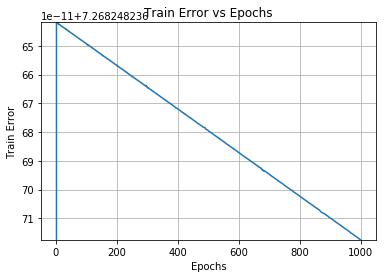

In [22]:
epochs = []
for i in range(0,1000):
    epochs.append(i+1)
plt.ylabel('Train Error')
plt.xlabel('Epochs')
plt.title("Train Error vs Epochs")
plt.grid(True)
plt.ylim(error_list[len(error_list)-1] , error_list[1])
plt.plot(epochs, error_list)

## Test Error vs Epochs

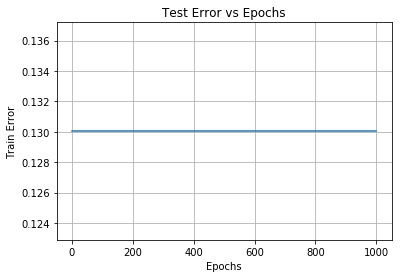

In [19]:
epochs = []
for i in range(0,1000):
    epochs.append(i+1)
plt.ylabel('Train Error')
plt.xlabel('Epochs')
plt.grid(True)
plt.title("Test Error vs Epochs")
plt.plot(epochs, test_error_list)

## Test Set

In [20]:
layer_0 = X_test
layer_1 = relu(np.dot(layer_0,b0))
layer_2 = sigmoid(np.dot(layer_1,b1))

In [21]:
correct = 0
for i in range(len(layer_2)):
    if(layer_2[i][0] > 0.5):
        layer_2[i][0] = 1
    else:
        layer_2[i][0] = 0
    if(layer_2[i][0] == y_test[i][0]):
        correct += 1
# printing the output
print('total =', len(layer_2))
print('correct =', correct)
print ('accuracy = ', correct * 100.0 / len(layer_2))

total = 1115
correct = 970
accuracy =  86.99551569506727
